# 1. Convex optimization for estimating covariance

In [3]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

# Below is an adaptation to Aditi's code
def estimate_theta(y, sparsity_pattern, n):
    """
    Estimate the covariance matrix Theta directly using sparse Cholesky decomposition and likelihood.

    Parameters:
        y (numpy.ndarray): Observed data vector.
        sparsity_pattern (list of lists): List of indices defining sparsity pattern for each row/column.
        n (int): Size of the covariance matrix.
        

    Returns:
        numpy.ndarray: Estimated covariance matrix Theta.
    """
    Theta = cp.Variable((n, n), PSD=True)  # PSD enforces positive definiteness

    # Enforce sparsity pattern
    constraints = []
    for i in range(n):
        for j in range(n):
            if j not in sparsity_pattern[i]:
                constraints.append(Theta[i, j] == 0)

    # Negative log-likelihood objective
    quadratic_term = 0.5 * cp.quad_form(y, Theta)  # y^T * Theta^-1 * y (quadratic term), return scaler

    # Log-determinant term
    log_det_term = cp.log_det(Theta)  # log(det(Theta))

    normalization_term = 0.5 * n * np.log(2 * np.pi)

    # Combine the terms into the objective
    objective = cp.Minimize(quadratic_term - log_det_term + normalization_term)

    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    return Theta.value

# Example usage
n = 5  # Size of the matrix
y = np.random.randn(n)
# Only entries defined in sparity pattern are non-zero.
sparsity_pattern = [[0, 1], [1, 2], [2, 3], [3, 4], [4]]  #Almost tridiagonal 
Theta_estimated = estimate_theta(y, sparsity_pattern, n)
print("Estimated Theta:\n", pd.DataFrame(Theta_estimated))

Estimated Theta:
               0             1             2             3             4
0  2.188790e+00 -6.651701e-09  1.714072e-08 -1.539851e-08 -4.309542e-09
1 -6.651701e-09  5.253974e+01  7.018120e-09 -3.148901e-09 -8.799303e-10
2  1.714072e-08  7.018120e-09  1.966672e+00  3.241454e-08  4.546923e-09
3 -1.539851e-08 -3.148901e-09  3.241454e-08  2.440869e+00 -8.160943e-09
4 -4.309542e-09 -8.799303e-10  4.546923e-09 -8.160943e-09  3.125544e+01


Text(20, 0.21479585909113738, 'Slope: -0.508')

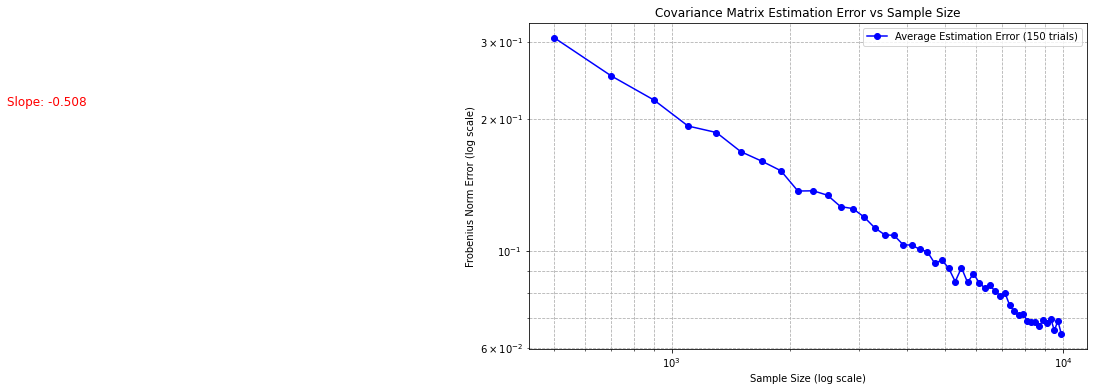

In [107]:
# Parameters
n = 5  # Size of the matrix
num_trials = 150  # Number of trials for averaging
# sample_sizes = [10, 20, 50, 100, 200, 500, 1000]
sample_sizes = range(500, 10001, 200)
errors_avg = []

# Generate true Theta with a tridiagonal sparsity pattern (1, -2, 1)
true_theta = np.eye(n) * -2
for i in range(n - 1):
    true_theta[i, i + 1] = 1
    true_theta[i + 1, i] = 1

# Ensure positive definiteness
min_eig = np.min(np.linalg.eigvalsh(true_theta))
if min_eig <= 0:
    true_theta += (np.eye(n) * (0.1 - min_eig))

# Define sparsity pattern based on true_theta's non-zero entries
sparsity_pattern = [[j for j in range(n) if true_theta[i, j] != 0] for i in range(n)]

# Function to estimate precision matrix
def estimate_theta(YTY, sparsity_pattern, n, m):
    Theta = cp.Variable((n, n), PSD=True)
    constraints = [Theta[i, j] == 0 for i in range(n) for j in range(n) if j not in sparsity_pattern[i]]
    quadratic_term = 0.5 * cp.trace(Theta @ YTY)
    log_det_term = (m / 2) * cp.log_det(Theta)
    objective = cp.Minimize(quadratic_term - log_det_term)
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)
    return Theta.value

# Main experiment loop with averaging over multiple trials
for m in sample_sizes:
    errors = []
    for _ in range(num_trials):
        Sigma = np.linalg.inv(true_theta)  # Compute covariance matrix
        Y = np.random.multivariate_normal(mean=np.zeros(n), cov=Sigma, size=m)
        YTY = Y.T @ Y  # Compute sufficient statistic
        Theta_est = estimate_theta(YTY, sparsity_pattern, n, m)
        error = np.linalg.norm(Theta_est - true_theta, 'fro')  # Frobenius norm
        errors.append(error)
    
    # Compute average error over trials
    errors_avg.append(np.mean(errors))

# Convert to log-log scale
log_sample_sizes = np.log(sample_sizes)
log_errors_avg = np.log(errors_avg)

# Use last few data points to compute slope (asmptotically)
slope, intercept = np.polyfit(log_sample_sizes[3:], log_errors_avg[3:], 1)

# Plot results with logarithmic scales
plt.figure(figsize=(10, 6))
plt.loglog(sample_sizes, errors_avg, 'bo-', label='Average Estimation Error (150 trials)')
plt.xlabel('Sample Size (log scale)')
plt.ylabel('Frobenius Norm Error (log scale)')
plt.title('Covariance Matrix Estimation Error vs Sample Size')
plt.grid(True, which='both', linestyle='--')
plt.legend()

# Display slope on the plot
plt.text(20, max(errors_avg) * 0.7, f'Slope: {slope:.3f}', fontsize=12, color='red')

In [110]:
pd.DataFrame(Theta_est)

,0,1,2,3,4
0,1.848112e+00,9.889583e-01,-2.598711e-11,1.899945e-11,-2.096326e-11
1,9.889583e-01,1.828609e+00,1.038215e+00,-1.591242e-11,4.915243e-12
2,-2.598711e-11,1.038215e+00,1.818044e+00,9.572300e-01,2.028961e-11
3,1.899945e-11,-1.591242e-11,9.572300e-01,1.874852e+00,1.047441e+00
4,-2.096326e-11,4.915243e-12,2.028961e-11,1.047441e+00,1.864367e+00


## 1.1 Sample size vs sparsity (Fisher's theorem study)

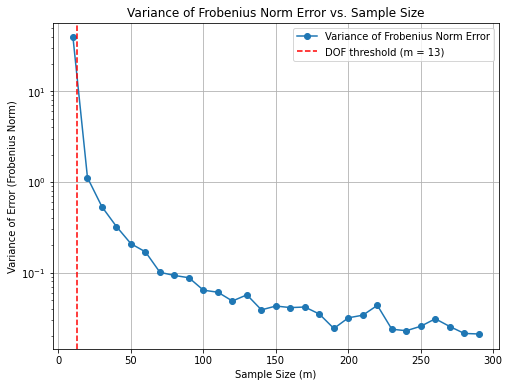

In [58]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# --- Setup the true precision matrix Theta ---
n = 5  # Size of the matrix

# Create a tridiagonal precision matrix with pattern (1, -2, 1)
true_theta = np.eye(n) * -2
for i in range(n - 1):
    true_theta[i, i + 1] = 1
    true_theta[i + 1, i] = 1

# Ensure positive definiteness by shifting if needed
min_eig = np.min(np.linalg.eigvalsh(true_theta))
if min_eig <= 0:
    true_theta += np.eye(n) * (0.1 - min_eig)

# Compute the true covariance matrix (for data generation)
true_cov = np.linalg.inv(true_theta)

# Define the sparsity pattern: list of column indices where each row has nonzero entries.
sparsity_pattern = [[j for j in range(n) if abs(true_theta[i, j]) > 1e-8] for i in range(n)]

# --- Function to estimate Theta using CVXPY ---
def estimate_theta(YTY, sparsity_pattern, n, m):
    Theta = cp.Variable((n, n), PSD=True)
    # Enforce sparsity: force entries not in the pattern to zero.
    constraints = [Theta[i, j] == 0 for i in range(n) for j in range(n) if j not in sparsity_pattern[i]]
    quadratic_term = 0.5 * cp.trace(Theta @ YTY)
    log_det_term = (m / 2) * cp.log_det(Theta)
    objective = cp.Minimize(quadratic_term - log_det_term)
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS, verbose=False)
    return Theta.value

# --- Simulation: Compute variance of Frobenius norm error over multiple trials ---
num_trials = 150  # Number of trials per sample size
sample_sizes = range(10, 300, 10)  # Vary sample size m from 10 to 300
error_variances = {}  # To store variance of Frobenius norm errors for each m

for m in sample_sizes:
    errors = []
    for trial in range(num_trials):
        # Generate m samples from N(0, true_cov)
        Y = np.random.multivariate_normal(np.zeros(n), true_cov, size=m)
        YTY = Y.T @ Y  # Scatter (covariance) matrix based on the samples
        Theta_est = estimate_theta(YTY, sparsity_pattern, n, m)
        if Theta_est is not None:
            # Compute the Frobenius norm error between the estimated and true precision matrices.
            error = np.linalg.norm(Theta_est - true_theta, 'fro')
            errors.append(error)
    # Store the variance of the errors for this sample size.
    error_variances[m] = np.var(errors)

# --- Plot the Variance vs. Sample Size (using a semilogy plot) ---
plt.figure(figsize=(8, 6))
plt.semilogy(list(error_variances.keys()),
             list(error_variances.values()),
             marker='o',
             label='Variance of Frobenius Norm Error')

plt.xlabel("Sample Size (m)")
plt.ylabel("Variance of Error (Frobenius Norm)")
plt.title("Variance of Frobenius Norm Error vs. Sample Size")

# Determine the "degrees of freedom" threshold.
# Total number of nonzero entries in the precision matrix.
dof_threshold = sum(len(p) for p in sparsity_pattern)  # For the 5x5 tridiagonal, this equals 13
plt.axvline(x=dof_threshold, color='red', linestyle='--',
            label=f'DOF threshold (m = {dof_threshold})')


plt.legend()
plt.grid(True)
plt.show()


In [59]:
print('Variance:',pd.DataFrame(list(error_variances.values())))

Variance:             0
0   39.192609
1    1.114910
2    0.531291
3    0.321662
4    0.207920
5    0.169217
6    0.100613
7    0.092925
8    0.087656
9    0.063918
10   0.060686
11   0.048547
12   0.056826
13   0.038779
14   0.042739
15   0.041090
16   0.041678
17   0.034869
18   0.024179
19   0.031688
20   0.033892
21   0.043470
22   0.023712
23   0.022838
24   0.025594
25   0.030925
26   0.025401
27   0.021307
28   0.021023


## This plot shows degree of freedom (DOF) impact more clearly
## After (DOF) threshold we see greater decay than Fisher's 1/m result

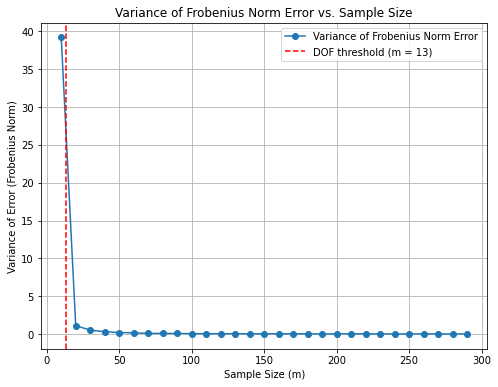

In [60]:
plt.figure(figsize=(8, 6))
plt.plot(list(error_variances.keys()),
           list(error_variances.values()),
           marker='o',
           label='Variance of Frobenius Norm Error')

plt.xlabel("Sample Size (m)")
plt.ylabel("Variance of Error (Frobenius Norm)")
plt.title("Variance of Frobenius Norm Error vs. Sample Size")
plt.axvline(x=dof_threshold, color='red', linestyle='--',
            label=f'DOF threshold (m = {dof_threshold})')

plt.legend()
plt.grid(True)
plt.show()

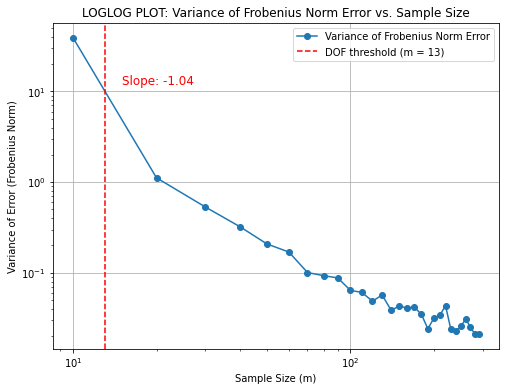

In [61]:
# --- Compute the slope using the last few data points ---
num_points_for_slope = 20  # Use last 5 points for estimation
x_vals = np.array(list(error_variances.keys())[-num_points_for_slope:])
y_vals = np.array(list(error_variances.values())[-num_points_for_slope:])

# Compute slope using log differences
log_x = np.log(x_vals)
log_y = np.log(y_vals)
slope = (log_y[-1] - log_y[0]) / (log_x[-1] - log_x[0])

# --- Plot the Variance vs. Sample Size (using a log-log plot) ---
plt.figure(figsize=(8, 6))
plt.loglog(list(error_variances.keys()),
           list(error_variances.values()),
           marker='o',
           label='Variance of Frobenius Norm Error')

plt.xlabel("Sample Size (m)")
plt.ylabel("Variance of Error (Frobenius Norm)")
plt.title("LOGLOG PLOT: Variance of Frobenius Norm Error vs. Sample Size")

# Add vertical dashed line at the degrees-of-freedom threshold.
plt.axvline(x=dof_threshold, color='red', linestyle='--',
            label=f'DOF threshold (m = {dof_threshold})')

# Display computed slope on the plot
plt.text(15, max(error_variances.values()) * 0.3, f"Slope: {slope:.2f}",
         fontsize=12, color='red')

plt.legend()
plt.grid(True)
plt.show()

## - Five-Diagonal (fixed)

## The slope is -2 for the 5 diagonal matrix, -3 for the 3 diagonal matrix.

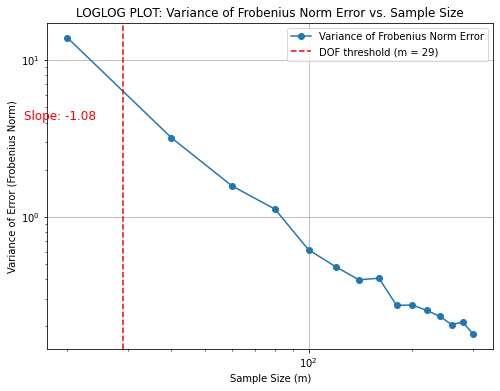

Computed slope: -1.08


In [62]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# --- Setup the true precision matrix Theta ---
n = 7  # Size of the matrix

# Construct five-diagonal precision matrix 
true_theta = np.eye(n) * -2  
true_theta += np.diag(np.ones(n - 1), k=1)  
true_theta += np.diag(np.ones(n - 1), k=-1)  
true_theta += np.diag(3*np.ones(n - 2), k=2)  
true_theta += np.diag(3*np.ones(n - 2), k=-2)  


# Ensure positive definiteness by shifting if needed
min_eig = np.min(np.linalg.eigvalsh(true_theta))
if min_eig <= 0:
    true_theta += np.eye(n) * (0.1 - min_eig)

# Compute the true covariance matrix (for data generation)
true_cov = np.linalg.inv(true_theta)

# Define the sparsity pattern: list of column indices where each row has nonzero entries.
sparsity_pattern = [[j for j in range(n) if abs(true_theta[i, j]) > 1e-8] for i in range(n)]

# --- Function to estimate Theta using CVXPY ---
def estimate_theta(YTY, sparsity_pattern, n, m):
    Theta = cp.Variable((n, n), PSD=True)
    # Enforce sparsity: force entries not in the pattern to zero.
    constraints = [Theta[i, j] == 0 for i in range(n) for j in range(n) if j not in sparsity_pattern[i]]
    quadratic_term = 0.5 * cp.trace(Theta @ YTY)
    log_det_term = (m / 2) * cp.log_det(Theta)
    objective = cp.Minimize(quadratic_term - log_det_term)
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS, verbose=False)
    return Theta.value

# --- Simulation: Compute variance of Frobenius norm error over multiple trials ---
num_trials = 500  # Number of trials per sample size
sample_sizes = range(20, 320, 20)  # Vary sample size m from 20 to 300
error_variances = {}  # To store variance of Frobenius norm errors for each m

for m in sample_sizes:
    errors = []
    for trial in range(num_trials):
        # Generate m samples from N(0, true_cov)
        Y = np.random.multivariate_normal(np.zeros(n), true_cov, size=m)
        YTY = Y.T @ Y  # Scatter (covariance) matrix based on the samples
        Theta_est = estimate_theta(YTY, sparsity_pattern, n, m)
        if Theta_est is not None:
            # Compute the Frobenius norm error between the estimated and true precision matrices.
            error = np.linalg.norm(Theta_est - true_theta, 'fro')
            errors.append(error)
    # Store the variance of the errors for this sample size.
    error_variances[m] = np.var(errors)

# --- Compute the slope using the last few data points ---
num_points_for_slope = 10  # Use last 10 points for estimation
x_vals = np.array(list(error_variances.keys())[-num_points_for_slope:])
y_vals = np.array(list(error_variances.values())[-num_points_for_slope:])

# Compute slope using log differences
log_x = np.log(x_vals)
log_y = np.log(y_vals)
slope = (log_y[-1] - log_y[0]) / (log_x[-1] - log_x[0])

# --- Plot the Variance vs. Sample Size (using a log-log plot) ---
plt.figure(figsize=(8, 6))
plt.loglog(list(error_variances.keys()),
           list(error_variances.values()),
           marker='o',
           label='Variance of Frobenius Norm Error')

plt.xlabel("Sample Size (m)")
plt.ylabel("Variance of Error (Frobenius Norm)")
plt.title("LOGLOG PLOT: Variance of Frobenius Norm Error vs. Sample Size")


# Determine the "degrees of freedom" threshold.
# Total number of nonzero entries in the precision matrix.
dof_threshold = sum(len(p) for p in sparsity_pattern)
plt.axvline(x=dof_threshold, color='red', linestyle='--',
            label=f'DOF threshold (m = {dof_threshold})')

# Display computed slope on the plot
plt.text(15, max(error_variances.values()) * 0.3, f"Slope: {slope:.2f}",
         fontsize=12, color='red')

plt.legend()
plt.grid(True)
plt.show()

# Print the computed slope
print(f"Computed slope: {slope:.2f}")


## - Fully Random

/Users/kingsleyyeon/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


WARNING - large complementary slackness residual: 0.487552
WARNING - large complementary slackness residual: 0.867259
WARNING - large complementary slackness residual: 0.492353
WARNING - large complementary slackness residual: 0.394518
WARNING - large complementary slackness residual: 0.684698
WARNING - large complementary slackness residual: 0.508181
WARNING - large complementary slackness residual: 0.509728


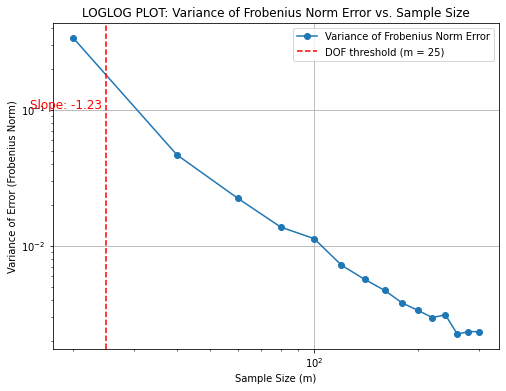

Computed slope: -1.23


In [63]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# --- Setup the true precision matrix Theta ---
n = 5  # Size of the matrix

# Generate a completely random symmetric precision matrix
random_matrix = np.random.randn(n, n)
true_theta = random_matrix @ random_matrix.T  # Ensure symmetric positive-definiteness

# Normalize to keep eigenvalues well-scaled
true_theta /= np.linalg.norm(true_theta, ord=2)

# Compute the true covariance matrix (for data generation)
true_cov = np.linalg.inv(true_theta)

# Define the sparsity pattern based on the nonzero entries of true_theta
sparsity_pattern = [[j for j in range(n) if abs(true_theta[i, j]) > 1e-8] for i in range(n)]

# --- Function to estimate Theta using CVXPY ---
def estimate_theta(YTY, sparsity_pattern, n, m):
    Theta = cp.Variable((n, n), PSD=True)
    # Enforce sparsity: force entries not in the pattern to zero.
    constraints = [Theta[i, j] == 0 for i in range(n) for j in range(n) if j not in sparsity_pattern[i]]
    quadratic_term = 0.5 * cp.trace(Theta @ YTY)
    log_det_term = (m / 2) * cp.log_det(Theta)
    objective = cp.Minimize(quadratic_term - log_det_term)
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS, verbose=False)
    return Theta.value

# --- Simulation: Compute variance of Frobenius norm error over multiple trials ---
num_trials = 500  # Number of trials per sample size
sample_sizes = range(20, 320, 20)  # Vary sample size m from 20 to 300
error_variances = {}  # To store variance of Frobenius norm errors for each m

for m in sample_sizes:
    errors = []
    for trial in range(num_trials):
        # Generate m samples from N(0, true_cov)
        Y = np.random.multivariate_normal(np.zeros(n), true_cov, size=m)
        YTY = Y.T @ Y  # Scatter (covariance) matrix based on the samples
        Theta_est = estimate_theta(YTY, sparsity_pattern, n, m)
        if Theta_est is not None:
            # Compute the Frobenius norm error between the estimated and true precision matrices.
            error = np.linalg.norm(Theta_est - true_theta, 'fro')
            errors.append(error)
    # Store the variance of the errors for this sample size.
    error_variances[m] = np.var(errors)

# --- Compute the slope using the last few data points ---
num_points_for_slope = 10  # Use last 10 points for estimation
x_vals = np.array(list(error_variances.keys())[-num_points_for_slope:])
y_vals = np.array(list(error_variances.values())[-num_points_for_slope:])

# Compute slope using log differences
log_x = np.log(x_vals)
log_y = np.log(y_vals)
slope = (log_y[-1] - log_y[0]) / (log_x[-1] - log_x[0])

# --- Plot the Variance vs. Sample Size (using a log-log plot) ---
plt.figure(figsize=(8, 6))
plt.loglog(list(error_variances.keys()),
           list(error_variances.values()),
           marker='o',
           label='Variance of Frobenius Norm Error')

plt.xlabel("Sample Size (m)")
plt.ylabel("Variance of Error (Frobenius Norm)")
plt.title("LOGLOG PLOT: Variance of Frobenius Norm Error vs. Sample Size")

# Determine the "degrees of freedom" threshold.
# Total number of nonzero entries in the precision matrix.
dof_threshold = sum(len(p) for p in sparsity_pattern)
plt.axvline(x=dof_threshold, color='red', linestyle='--',
            label=f'DOF threshold (m = {dof_threshold})')

# Display computed slope on the plot
plt.text(15, max(error_variances.values()) * 0.3, f"Slope: {slope:.2f}",
         fontsize=12, color='red')

plt.legend()
plt.grid(True)
plt.show()

# Print the computed slope
print(f"Computed slope: {slope:.2f}")


## - Tridiagonal (random entries)

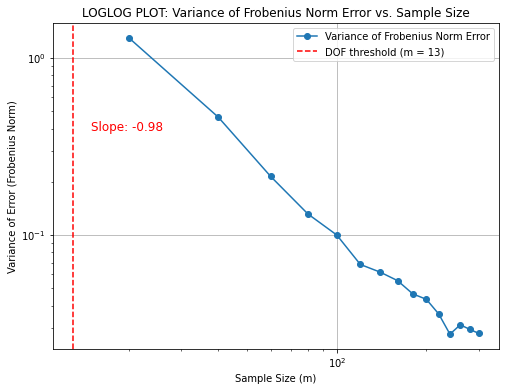

Computed slope: -0.98


In [64]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# --- Setup the true precision matrix Theta ---
n = 5  # Size of the matrix

# Generate a random tridiagonal precision matrix
main_diag = np.random.normal(-2, 0.5, n)  # Randomized diagonal entries
off_diag = np.random.normal(1, 0.2, n - 1)  # Randomized off-diagonal entries

true_theta = np.diag(main_diag)  # Place diagonals
true_theta += np.diag(off_diag, k=1)  # Upper diagonal
true_theta += np.diag(off_diag, k=-1)  # Lower diagonal

# Ensure positive definiteness
min_eig = np.min(np.linalg.eigvalsh(true_theta))
if min_eig <= 0:
    true_theta += np.eye(n) * (0.1 - min_eig)

# Compute the true covariance matrix (for data generation)
true_cov = np.linalg.inv(true_theta)

# Define the sparsity pattern based on the nonzero entries of true_theta
sparsity_pattern = [[j for j in range(n) if abs(true_theta[i, j]) > 1e-8] for i in range(n)]

# --- Function to estimate Theta using CVXPY ---
def estimate_theta(YTY, sparsity_pattern, n, m):
    Theta = cp.Variable((n, n), PSD=True)
    # Enforce sparsity: force entries not in the pattern to zero.
    constraints = [Theta[i, j] == 0 for i in range(n) for j in range(n) if j not in sparsity_pattern[i]]
    quadratic_term = 0.5 * cp.trace(Theta @ YTY)
    log_det_term = (m / 2) * cp.log_det(Theta)
    objective = cp.Minimize(quadratic_term - log_det_term)
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS, verbose=False)
    return Theta.value

# --- Simulation: Compute variance of Frobenius norm error over multiple trials ---
num_trials = 500  # Number of trials per sample size
sample_sizes = range(20, 320, 20)  # Vary sample size m from 20 to 300
error_variances = {}  # To store variance of Frobenius norm errors for each m

for m in sample_sizes:
    errors = []
    for trial in range(num_trials):
        # Generate m samples from N(0, true_cov)
        Y = np.random.multivariate_normal(np.zeros(n), true_cov, size=m)
        YTY = Y.T @ Y  # Scatter (covariance) matrix based on the samples
        Theta_est = estimate_theta(YTY, sparsity_pattern, n, m)
        if Theta_est is not None:
            # Compute the Frobenius norm error between the estimated and true precision matrices.
            error = np.linalg.norm(Theta_est - true_theta, 'fro')
            errors.append(error)
    # Store the variance of the errors for this sample size.
    error_variances[m] = np.var(errors)

# --- Compute the slope using the last few data points ---
num_points_for_slope = 10  # Use last 10 points for estimation
x_vals = np.array(list(error_variances.keys())[-num_points_for_slope:])
y_vals = np.array(list(error_variances.values())[-num_points_for_slope:])

# Compute slope using log differences
log_x = np.log(x_vals)
log_y = np.log(y_vals)
slope = (log_y[-1] - log_y[0]) / (log_x[-1] - log_x[0])

# --- Plot the Variance vs. Sample Size (using a log-log plot) ---
plt.figure(figsize=(8, 6))
plt.loglog(list(error_variances.keys()),
           list(error_variances.values()),
           marker='o',
           label='Variance of Frobenius Norm Error')

plt.xlabel("Sample Size (m)")
plt.ylabel("Variance of Error (Frobenius Norm)")
plt.title("LOGLOG PLOT: Variance of Frobenius Norm Error vs. Sample Size")

# Determine the "degrees of freedom" threshold.
# Total number of nonzero entries in the precision matrix.
dof_threshold = sum(len(p) for p in sparsity_pattern)
plt.axvline(x=dof_threshold, color='red', linestyle='--',
            label=f'DOF threshold (m = {dof_threshold})')

# Display computed slope on the plot
plt.text(15, max(error_variances.values()) * 0.3, f"Slope: {slope:.2f}",
         fontsize=12, color='red')

plt.legend()
plt.grid(True)
plt.show()

# Print the computed slope
print(f"Computed slope: {slope:.2f}")


## 2. Model selection, biased variance tradeoff

## Approximation error + Estimation error = Generalization error.

Approximation error: expressivity of model (i.e using Fourier series for periodic data) 

Estimation error: finite data              (i.e number of Fourier modes)



Theta_est for complexity 1 nonzero entries per row:

               Col 0         Col 1         Col 2         Col 3         Col 4  \
Row 0   1.396698e+00 -2.921411e-14 -2.333031e-14 -5.024656e-14 -6.134000e-14   
Row 1  -2.921411e-14  1.350777e+00  2.823867e-14  7.676391e-15 -1.114335e-13   
Row 2  -2.333031e-14  2.823867e-14  1.381549e+00  1.333597e-14 -1.209862e-13   
Row 3  -5.024656e-14  7.676391e-15  1.333597e-14  1.463306e+00 -2.154073e-14   
Row 4  -6.134000e-14 -1.114335e-13 -1.209862e-13 -2.154073e-14  4.791479e-01   
Row 5   3.191900e-14 -7.519312e-14 -5.864599e-14 -4.472592e-14  9.804244e-14   
Row 6   5.174768e-14  2.091881e-14 -3.895861e-14 -6.213531e-14 -4.922362e-14   
Row 7   3.039474e-14  4.878426e-14  4.877590e-14 -3.304511e-14 -1.434061e-13   
Row 8   1.986556e-14  1.476965e-13  1.631949e-13  7.719736e-14 -4.503570e-13   
Row 9  -6.676392e-14  2.488127e-15  2.152556e-14  6.190016e-14  7.519071e-14   
Row 10 -3.345283e-14 -7.609372e-14 -5.700958e-14  1.070392e-14  2.


Theta_est for complexity 4 nonzero entries per row:

               Col 0         Col 1         Col 2         Col 3         Col 4  \
Row 0   1.421942e+00  2.732120e-01 -4.045093e-13 -1.082063e-13  1.985079e-14   
Row 1   2.732120e-01  1.419608e+00 -2.851895e-01  1.599004e-13 -2.409587e-13   
Row 2  -4.045093e-13 -2.851895e-01  1.401520e+00 -1.415041e-01 -3.880628e-13   
Row 3  -1.082063e-13  1.599004e-13 -1.415041e-01  1.531173e+00  6.068441e-02   
Row 4   1.985079e-14 -2.409587e-13 -3.880628e-13  6.068441e-02  5.602293e-01   
Row 5   4.436245e-14 -1.093377e-13 -1.528114e-13 -1.541351e-13 -3.945010e-01   
Row 6   7.956673e-14 -1.394369e-13 -5.535524e-13 -3.262890e-12  5.283102e-11   
Row 7   2.007444e-13 -6.660568e-13 -2.438872e-12 -1.654392e-11  3.007501e-10   
Row 8   8.319461e-13 -3.185086e-12 -1.154628e-11 -7.815760e-11  1.433702e-09   
Row 9  -5.978336e-14  4.191871e-14  1.618361e-13  9.958668e-13 -1.724210e-11   
Row 10 -2.559936e-14 -5.793411e-14 -3.001123e-14  1.360453e-13 -2.


Theta_est for complexity 7 nonzero entries per row:

               Col 0         Col 1         Col 2         Col 3         Col 4  \
Row 0   1.732226e+00  2.810519e-01  1.792416e-01  6.477219e-01 -1.185415e-11   
Row 1   2.810519e-01  1.697315e+00  1.269186e-01  6.363143e-02  5.105958e-01   
Row 2   1.792416e-01  1.269186e-01  1.968444e+00  8.837684e-02  4.851366e-01   
Row 3   6.477219e-01  6.363143e-02  8.837684e-02  2.297053e+00  5.056580e-02   
Row 4  -1.185415e-11  5.105958e-01  4.851366e-01  5.056580e-02  1.152534e+00   
Row 5  -1.511404e-11 -7.513786e-13  4.822370e-01  4.972329e-01 -2.542934e-01   
Row 6  -1.863129e-11  1.811535e-12 -7.176694e-12  8.603939e-01  1.925376e-01   
Row 7  -9.099934e-13 -4.065040e-12 -1.267552e-11  3.949157e-12  8.118490e-01   
Row 8   2.171751e-11 -2.828396e-11 -8.104914e-11 -3.389719e-11  6.562451e-11   
Row 9   2.991169e-11 -2.282282e-11 -1.540172e-11 -3.059223e-11  4.941566e-11   
Row 10  2.539113e-12  6.390573e-12  2.999048e-11  8.783197e-13 -5.


Theta_est for complexity 10 nonzero entries per row:

               Col 0         Col 1         Col 2         Col 3         Col 4  \
Row 0   2.644198e+00  1.116929e+00  1.051840e+00  1.005745e+00  1.065748e+00   
Row 1   1.116929e+00  2.555742e+00  7.549783e-01  6.437259e-01  8.990900e-01   
Row 2   1.051840e+00  7.549783e-01  3.045335e+00  1.094305e+00  1.310805e+00   
Row 3   1.005745e+00  6.437259e-01  1.094305e+00  3.088805e+00  1.114503e+00   
Row 4   1.065748e+00  8.990900e-01  1.310805e+00  1.114503e+00  2.813193e+00   
Row 5  -2.643565e-13  9.935296e-01  7.580095e-01  1.018524e+00  9.751523e-01   
Row 6  -2.408563e-12 -3.581673e-12  1.196031e+00  1.221949e+00  1.022433e+00   
Row 7   1.729849e-12 -1.720564e-12 -1.050474e-11  1.172107e+00  1.224836e+00   
Row 8   9.118844e-12  2.074088e-12 -5.484296e-12 -2.026191e-11  1.080253e+00   
Row 9   9.061790e-12  4.710047e-12  1.853235e-12 -1.323720e-11 -1.798420e-11   
Row 10  9.065157e-13  9.148012e-12  8.138236e-12 -4.452805e-12 -1


Theta_est for complexity 13 nonzero entries per row:

               Col 0         Col 1         Col 2         Col 3         Col 4  \
Row 0   2.661745e+00  1.099367e+00  1.045698e+00  1.050663e+00  1.081301e+00   
Row 1   1.099367e+00  2.580982e+00  8.111652e-01  6.653632e-01  9.342232e-01   
Row 2   1.045698e+00  8.111652e-01  3.028742e+00  1.091377e+00  1.354746e+00   
Row 3   1.050663e+00  6.653632e-01  1.091377e+00  3.125014e+00  1.166552e+00   
Row 4   1.081301e+00  9.342232e-01  1.354746e+00  1.166552e+00  2.958544e+00   
Row 5  -3.725403e-03  1.020343e+00  8.235244e-01  1.026699e+00  1.015836e+00   
Row 6   2.644378e-02  1.207505e-02  1.225566e+00  1.293174e+00  1.126176e+00   
Row 7   3.181186e-13 -9.373586e-03  5.250320e-02  1.171634e+00  1.251232e+00   
Row 8   4.593170e-14  7.160864e-13  4.122017e-02  2.666418e-02  1.158898e+00   
Row 9   2.956980e-13  6.753502e-13 -5.712545e-13  2.035422e-03 -2.127299e-02   
Row 10  3.034816e-13  1.428198e-13 -2.780816e-13 -3.318019e-13 -6

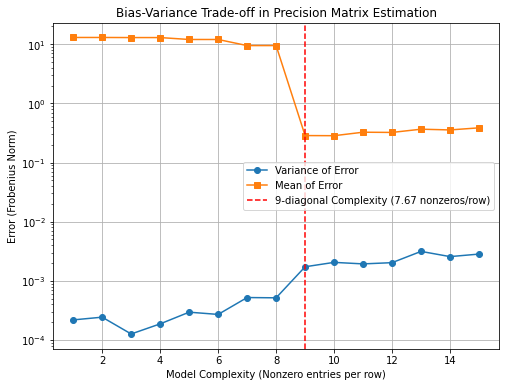

true_theta = 
           0         1         2         3         4         5         6   \
0   2.630003  1.120659  1.028171  0.998163  1.066954  0.000000  0.000000   
1   1.120659  2.582948  0.799505  0.664586  0.914159  1.013528  0.000000   
2   1.028171  0.799505  3.028752  1.043154  1.284452  0.782104  1.180884   
3   0.998163  0.664586  1.043154  3.087624  1.116363  0.993068  1.219441   
4   1.066954  0.914159  1.284452  1.116363  2.850944  0.965706  1.061022   
5   0.000000  1.013528  0.782104  0.993068  0.965706  3.671996  1.023064   
6   0.000000  0.000000  1.180884  1.219441  1.061022  1.023064  3.368192   
7   0.000000  0.000000  0.000000  1.199073  1.234757  0.982241  0.950995   
8   0.000000  0.000000  0.000000  0.000000  1.124545  0.938025  0.846244   
9   0.000000  0.000000  0.000000  0.000000  0.000000  0.878108  0.853171   
10  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  1.167764   
11  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000 

In [55]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

def generate_l_diagonal_matrix(n, l, diag_mean=-2, diag_std=0.5, offdiag_mean=1, offdiag_std=0.2):
    """
    Generate a random l-diagonal symmetric positive definite precision matrix of size n x n.
    """
    matrix = np.zeros((n, n))
    main_diag = np.random.normal(diag_mean, diag_std, n)
    np.fill_diagonal(matrix, main_diag)
    for band in range(1, l):
        off_diag = np.random.normal(offdiag_mean, offdiag_std, n - band)
        matrix += np.diag(off_diag, k=band) + np.diag(off_diag, k=-band)
    min_eig = np.min(np.linalg.eigvalsh(matrix))
    if min_eig <= 0:
        matrix += np.eye(n) * (0.1 - min_eig)
    return matrix

def create_sparsity_pattern(n, k):
    """
    Create a sparsity pattern with k nonzero entries per row from the diagonal outward.
    """
    sparsity_pattern = []
    half_bandwidth = (k - 1) // 2
    for i in range(n):
        indices = [i]
        for band in range(1, half_bandwidth + 1):
            if i - band >= 0:
                indices.append(i - band)
            if i + band < n:
                indices.append(i + band)
        sparsity_pattern.append(sorted(set(indices)))
    return sparsity_pattern

def estimate_theta(YTY, sparsity_pattern, n, m):
    Theta = cp.Variable((n, n), PSD=True)
    constraints = [Theta[i, j] == 0 for i in range(n) for j in range(n) if j not in sparsity_pattern[i]]
    objective = cp.Minimize(0.5 * cp.trace(Theta @ YTY) - (m / 2) * cp.log_det(Theta))
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS, verbose=False)
    return Theta.value

n = 15  # Matrix size
l = 5   # Half-bandwidth (5 lower + 5 upper diagonals = 9-diagonal matrix)
true_theta = generate_l_diagonal_matrix(n, l)
true_cov = np.linalg.inv(true_theta)

num_trials = 100
m = 10000
complexities = range(1, n + 1)

variance_list = []
mean_error_list = []

for k in complexities:
    errors = []
    sparsity_pattern = create_sparsity_pattern(n, k)
    for trial in range(num_trials):
        Y = np.random.multivariate_normal(np.zeros(n), true_cov, size=m)
        YTY = Y.T @ Y
        Theta_est = estimate_theta(YTY, sparsity_pattern, n, m)
        if Theta_est is not None:
            errors.append(np.linalg.norm(Theta_est - true_theta, 'fro'))
    Theta_est_df = pd.DataFrame(Theta_est, columns=[f"Col {i}" for i in range(n)], index=[f"Row {i}" for i in range(n)])
    print(f"\nTheta_est for complexity {k} nonzero entries per row:\n")
    print(Theta_est_df)
    is_valid = all(np.abs(Theta_est[i, j]) < 1e-8 for i in range(n) for j in range(n) if j not in sparsity_pattern[i])
    print(f"Constraints satisfied for complexity {k}: {is_valid}\n")
    variance_list.append(np.var(errors))
    mean_error_list.append(np.mean(errors))

# Compute the correct degrees of freedom for the chosen l-diagonal matrix
dof_threshold = n * (2 * l - 1) - (l * (l - 1))

plt.figure(figsize=(8, 6))
plt.semilogy(complexities, variance_list, marker='o', label='Variance of Error')
plt.semilogy(complexities, mean_error_list, marker='s', label='Mean of Error')
plt.xlabel("Model Complexity (Nonzero entries per row)")
plt.ylabel("Error (Frobenius Norm)")
plt.title("Bias-Variance Trade-off in Precision Matrix Estimation")

plt.axvline(x=9, color='red', linestyle='--', label=f'9-diagonal Complexity ({dof_threshold / n:.2f} nonzeros/row)')
plt.legend()
plt.grid(True)
plt.show()

print("true_theta = \n", pd.DataFrame(true_theta))


96

1.3809747324940773
1.0913879268117939
1.0034385924430393
0.9226961748890429
0.7897070628263908
0.7443468414611215
0.7417197771506621
0.6550082139014202
0.6353054788659508
0.6366612209502159
0.5684279701873723
0.5696631128493851
0.5397394177053907
0.53535411011949
0.5093049255909381
0.5088890959604382
0.49772191272826616
0.4702285501363914
0.4431269138278368
0.4343074940133592
0.4199648435174039
0.4145892467742799
0.41309679835070434
0.42316570732319986
0.40423201157832706
0.408764519558595
0.3884496846780921
0.38049776188348206
0.37798797646806676
0.37348404043351613
0.36355184484673186
0.3656214589663703
0.364836929961605
0.353565743200352
0.34506575207580836
0.34152782804330406
0.33343918538086553
0.3328876933657354
0.3329829887361692
0.31724598228441575
0.3176489851700429
0.3134007218855108
0.31047142082492873
0.3148111701074649
0.30116751266582825
0.29802392051982945
0.306515343372384
0.30231360520582357


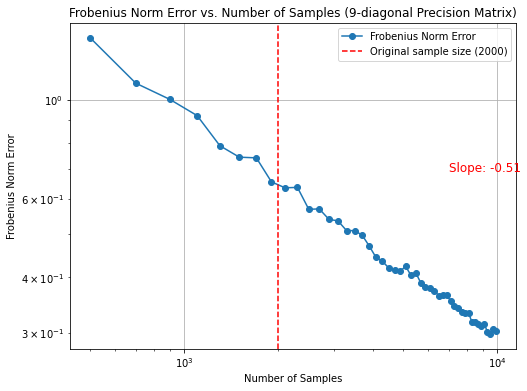

true_theta = 
           0         1         2         3         4         5         6   \
0   3.071620  1.151318  1.056844  0.865904  0.853690  0.000000  0.000000   
1   1.151318  2.683474  1.134010  1.196725  0.930052  1.017928  0.000000   
2   1.056844  1.134010  2.585057  1.026304  1.161817  1.336602  0.667069   
3   0.865904  1.196725  1.026304  2.320039  0.937292  0.582753  0.965582   
4   0.853690  0.930052  1.161817  0.937292  2.455774  0.918329  1.197286   
5   0.000000  1.017928  1.336602  0.582753  0.918329  2.240419  1.018977   
6   0.000000  0.000000  0.667069  0.965582  1.197286  1.018977  2.978262   
7   0.000000  0.000000  0.000000  0.718800  0.709256  0.890101  0.683613   
8   0.000000  0.000000  0.000000  0.000000  1.025587  1.231822  1.078945   
9   0.000000  0.000000  0.000000  0.000000  0.000000  1.291156  1.270732   
10  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.687659   
11  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000 

In [126]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

def generate_l_diagonal_matrix(n, l, diag_mean=-2, diag_std=0.5, offdiag_mean=1, offdiag_std=0.2):
    matrix = np.zeros((n, n))
    main_diag = np.random.normal(diag_mean, diag_std, n)
    np.fill_diagonal(matrix, main_diag)
    for band in range(1, l):
        off_diag = np.random.normal(offdiag_mean, offdiag_std, n - band)
        matrix += np.diag(off_diag, k=band) + np.diag(off_diag, k=-band)
    min_eig = np.min(np.linalg.eigvalsh(matrix))
    if min_eig <= 0:
        matrix += np.eye(n) * (0.1 - min_eig)
    return matrix

def create_sparsity_pattern(n, l):
    sparsity_pattern = []
    for i in range(n):
        indices = [i]
        for band in range(1, l):
            if i - band >= 0:
                indices.append(i - band)
            if i + band < n:
                indices.append(i + band)
        sparsity_pattern.append(sorted(set(indices)))
    return sparsity_pattern

def estimate_theta(YTY, sparsity_pattern, n, m):
    Theta = cp.Variable((n, n), PSD=True)
    constraints = [Theta[i, j] == 0 for i in range(n) for j in range(n) if j not in sparsity_pattern[i]]
    objective = cp.Minimize(0.5 * cp.trace(Theta @ YTY) - (m / 2) * cp.log_det(Theta))
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS, verbose=False)
    return Theta.value

n = 15
l = 5
true_theta = generate_l_diagonal_matrix(n, l)
true_cov = np.linalg.inv(true_theta)

num_trials = 50
sample_sizes = range(500, 10001, 200)  
frobenius_errors = []

sparsity_pattern = create_sparsity_pattern(n, l)

for m in sample_sizes:
    errors = []
    for trial in range(num_trials):
        Y = np.random.multivariate_normal(np.zeros(n), true_cov, size=m)
        YTY = Y.T @ Y
        Theta_est = estimate_theta(YTY, sparsity_pattern, n, m)
        if Theta_est is not None:
            errors.append(np.linalg.norm(Theta_est - true_theta, 'fro'))
    frobenius_errors.append(np.mean(errors))
    print(np.mean(errors))

# Calculate slope from the last 10 points
log_x = np.log(list(sample_sizes)[-90:])
log_y = np.log(frobenius_errors[-90:])
slope = (log_y[-1] - log_y[0]) / (log_x[-1] - log_x[0])

plt.figure(figsize=(8, 6))
plt.loglog(sample_sizes, frobenius_errors, marker='o', label='Frobenius Norm Error')
plt.xlabel("Number of Samples")
plt.ylabel("Frobenius Norm Error")
plt.title("Frobenius Norm Error vs. Number of Samples (9-diagonal Precision Matrix)")
plt.axvline(x=2000, color='red', linestyle='--', label='Original sample size (2000)')
plt.text(7000, max(frobenius_errors) * 0.5, f"Slope: {slope:.2f}", fontsize=12, color='red')
plt.legend()
plt.grid(True)
plt.show()

print("true_theta = \n", pd.DataFrame(true_theta))


In [75]:
pd.DataFrame(Theta_est)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2.043119e+00,1.270506e+00,9.343542e-01,8.275776e-01,1.098254e+00,-5.299360e-11,-1.875046e-11,2.891282e-11,2.650932e-11,3.563245e-11,-2.022368e-11,-9.747851e-11,-2.065701e-11,-8.136297e-12,1.468870e-10
1,1.270506e+00,1.804055e+00,7.969168e-01,1.074551e+00,1.158665e+00,7.888552e-01,-6.144571e-11,-2.630251e-11,5.687076e-11,3.620155e-11,4.915195e-11,-3.647861e-11,-1.234062e-10,-4.886984e-11,7.676816e-11
2,9.343542e-01,7.969168e-01,2.949503e+00,7.796804e-01,8.248273e-01,1.088983e+00,1.302235e+00,-2.829330e-11,-4.209247e-11,-6.753963e-12,1.607112e-11,8.258960e-11,3.475353e-11,-8.200275e-12,-1.233362e-10
3,8.275776e-01,1.074551e+00,7.796804e-01,2.994801e+00,6.882827e-01,8.451612e-01,1.287336e+00,9.475999e-01,-5.678029e-11,-2.139407e-11,-2.284483e-12,6.086830e-11,9.166645e-11,1.406433e-11,-1.227459e-10
4,1.098254e+00,1.158665e+00,8.248273e-01,6.882827e-01,2.665990e+00,8.798779e-01,1.220656e+00,6.157809e-01,1.067309e+00,-3.531324e-11,-2.161982e-11,6.073500e-11,4.384361e-11,5.684507e-11,-1.117230e-10
5,-5.299360e-11,7.888552e-01,1.088983e+00,8.451612e-01,8.798779e-01,2.730617e+00,6.971481e-01,1.169785e+00,4.722032e-01,8.915753e-01,-2.703928e-11,-5.197043e-11,1.578348e-11,1.146521e-11,9.267226e-11
6,-1.875046e-11,-6.144571e-11,1.302235e+00,1.287336e+00,1.220656e+00,6.971481e-01,3.065773e+00,8.703121e-01,1.139331e+00,8.364267e-01,9.586526e-01,-9.092550e-11,-4.970157e-11,-1.072463e-11,1.558193e-10
7,2.891282e-11,-2.630251e-11,-2.829330e-11,9.475999e-01,6.157809e-01,1.169785e+00,8.703121e-01,3.235979e+00,8.109003e-01,9.881424e-01,8.481513e-01,8.447575e-01,-5.544743e-11,-1.709459e-11,8.453767e-12
8,2.650932e-11,5.687076e-11,-4.209247e-11,-5.678029e-11,1.067309e+00,4.722032e-01,1.139331e+00,8.109003e-01,2.451236e+00,1.099127e+00,1.151893e+00,1.087753e+00,1.432522e+00,-4.772315e-11,-4.007014e-11
9,3.563245e-11,3.620155e-11,-6.753963e-12,-2.139407e-11,-3.531324e-11,8.915753e-01,8.364267e-01,9.881424e-01,1.099127e+00,3.456223e+00,1.115056e+00,1.195839e+00,8.840525e-01,8.245365e-01,-6.563280e-11


## Next, generate from $a_{ij} = e^{-(i-j)^2/\sigma}$ and predict the optimal sparisity pattern. 

Previous has a strong assumption on exact sparsity, but in general we know any covariance matrix has a HODLR form, so LL^T and L is sparse!

Change optimization to use Cholesky such that L in Cholesky is sparse, how to pick sparsity pattern for L?

Use the Cholesky paper to pick sparisty pattern!

Given a new data point, initialize optimization from last fixed point or use S-M formula to update?

In [134]:
# Generate synthetic data: n samples of p-dimensional vectors
np.random.seed(42)
n, p = 100, 5
X = np.random.randn(n, p)

# Compute the sample mean
mean_vector = np.mean(X, axis=0)

# Define u_i = (x_i - mean) / sqrt(n)
U = (X - mean_vector) / np.sqrt(n)

# Compute covariance matrix from u's (this equals the covariance matrix computed as 1/n sum_i outer)
cov = np.zeros((p, p))
for i in range(n):
    cov += np.outer(U[i], U[i])
    
# Check that 'cov' is indeed the covariance matrix (matches np.cov with ddof=0)
cov_numpy = np.cov(X, rowvar=False, ddof=0)
print("Difference between manual covariance and np.cov:", np.linalg.norm(cov - cov_numpy))

# ---- Iterative Sherman–Morrison Update ----
# We want to compute the inverse of:
# A = sum_{i=0}^{n-1} u_i u_i^T
# Since a single rank-1 term is singular for p>1,
# we initialize with the sum of the first p outer products.
A_init = np.zeros((p, p))
for i in range(p):
    A_init += np.outer(U[i], U[i])

# Check that A_init is invertible
if np.linalg.matrix_rank(A_init) < p:
    raise ValueError("Initial matrix is not full rank. Try a different ordering or add regularization.")

A_inv = np.linalg.inv(A_init)  # Inverse of the initial sum

# Update A_inv iteratively for the remaining terms using Sherman–Morrison formula
for i in range(p, n):
    u = U[i]
    # Compute the denominator: 1 + u^T A_inv u
    denom = 1 + u.T @ A_inv @ u
    # Update A_inv
    A_inv = A_inv - (A_inv @ np.outer(u, u) @ A_inv) / denom
#     print(i,':', pd.DataFrame(A_inv))

# A_inv now should be the inverse of our covariance matrix (precision matrix)
precision_sm = A_inv

# Compute the precision matrix using numpy's inverse (cov must be invertible)
precision_numpy = np.linalg.inv(cov)

# Compare the two precision matrices
diff_norm = np.linalg.norm(precision_sm - precision_numpy)
print("Difference between precision matrices (Sherman–Morrison vs np.linalg.inv):", diff_norm)

# Optionally, print the matrices
print("\nPrecision matrix (Sherman–Morrison):\n", precision_sm)
print("\nPrecision matrix (np.linalg.inv):\n", precision_numpy)


Difference between manual covariance and np.cov: 7.900175258398163e-16
Difference between precision matrices (Sherman–Morrison vs np.linalg.inv): 1.5266217096039445e-15

Precision matrix (Sherman–Morrison):
 [[ 1.31733205  0.19493774 -0.08508749  0.11629082  0.13071634]
 [ 0.19493774  1.09212043 -0.14047882 -0.02231823 -0.0307326 ]
 [-0.08508749 -0.14047882  1.06619376 -0.01105467 -0.04333608]
 [ 0.11629082 -0.02231823 -0.01105467  1.1092162  -0.00429441]
 [ 0.13071634 -0.0307326  -0.04333608 -0.00429441  0.89487857]]

Precision matrix (np.linalg.inv):
 [[ 1.31733205  0.19493774 -0.08508749  0.11629082  0.13071634]
 [ 0.19493774  1.09212043 -0.14047882 -0.02231823 -0.0307326 ]
 [-0.08508749 -0.14047882  1.06619376 -0.01105467 -0.04333608]
 [ 0.11629082 -0.02231823 -0.01105467  1.1092162  -0.00429441]
 [ 0.13071634 -0.0307326  -0.04333608 -0.00429441  0.89487857]]


## Do Sherman-Morrison to update L directly.

# 3. Closed form solution of Cholesky factor for estimating covariance

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import time

def boundary_dist_func(point):
    return np.linalg.norm(point)

def reverse_maximin_ordering(points):  
    """
    Order points from furthest to closest from the origin.
    Returns a permutation (list of indices).
    """
    n = points.shape[0]
    ordering = []
    remaining = set(range(n))
    while remaining:
        max_dist = -1
        next_point = -1
        for i in remaining:
            dist = boundary_dist_func(points[i])
            if dist > max_dist:
                max_dist = dist
                next_point = i
        ordering.append(next_point)
        remaining.remove(next_point)
    return ordering

def compute_sparsity_pattern_perm(points, rho):
    """
    Given points in the permuted (elimination) order, compute a sparsity pattern.
    For each point i, we include all indices j (with j>=i) for which
      distance(points[i], points[j]) <= rho * boundary_dist_func(points[i]).
    """
    n = points.shape[0]
    tree = KDTree(points)
    sparsity = [[] for _ in range(n)]
    for i in range(n):
        radius = rho * boundary_dist_func(points[i])
        neighbors = tree.query_ball_point(points[i], radius)
        # Only keep neighbors that come later in the ordering
        sparsity[i] = [j for j in neighbors if j >= i]
    return sparsity

def kl_minimization_column(Theta_sk_sk):
    """
    Given the submatrix Theta_sk_sk corresponding to an index set sk,
    compute the vector L_sk solving a certain minimization problem.
    (This is a closed-form formula from the paper.)
    """
    reg = 1e-3 * np.eye(len(Theta_sk_sk))  # regularization term
    print('Shape of sub_matrix used for inversion:',np.shape(Theta_sk_sk))
    inv = np.linalg.inv(Theta_sk_sk + reg)
    e1 = np.zeros(len(inv))
    e1[0] = 1
    L_sk = inv @ e1
    L_sk /= np.sqrt(e1 @ inv @ e1)
    return L_sk

# ============================
# Generate synthetic data
# ============================
np.random.seed(0)
n = 500
d = 1
points = np.random.randn(n, d)

def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y)**2 / (2 * sigma**2))

# Create full covariance matrix using the Gaussian kernel
Theta_true = np.array([[gaussian_kernel(points[i], points[j])
                        for j in range(n)] for i in range(n)])

# ============================
# Small-scale test case
# ============================
matsize = 10   # Test matrix size
subset = np.array(list(range(matsize)))  # indices of the subset
# Regularize the small covariance submatrix
Theta_sub = Theta_true[np.ix_(subset, subset)] + 1e-3 * np.eye(matsize)

# ----------------------------
# Reorder the data according to reverse maximin ordering.
# ----------------------------
ordering = reverse_maximin_ordering(points[subset])
# Permute the points and Theta_sub into the elimination order
points_perm = points[subset][ordering]
Theta_sub_perm = Theta_sub[np.ix_(ordering, ordering)]

# ----------------------------
# Compute the sparsity pattern in the permuted ordering.
# ----------------------------
rho = 2
sparsity_perm = compute_sparsity_pattern_perm(points_perm, rho)

# ----------------------------
# Compute the approximate factor L in the permuted ordering.
# ----------------------------
L_perm = np.zeros((matsize, matsize))
for i in range(matsize):
    # Use the sparsity pattern for the i-th column.
    sk = sparsity_perm[i]
    # Ensure that the diagonal (i) is included and appears first.
    if i not in sk:
        sk = [i]
    else:
        # Force diagonal first if not already
        sk = [i] + [j for j in sk if j != i]
    Theta_sk_sk = Theta_sub_perm[np.ix_(sk, sk)]
    L_sk = kl_minimization_column(Theta_sk_sk)
    L_perm[sk, i] = L_sk

# ----------------------------
# Reconstruct the approximate covariance matrix in the permuted ordering.
# ----------------------------
Theta_est_perm = np.linalg.pinv(L_perm @ L_perm.T)

# ----------------------------
# Undo the permutation to get the estimate back in the original ordering.
# ----------------------------
# Compute the inverse permutation
ip = np.argsort(ordering)
Theta_est = Theta_est_perm[np.ix_(ip, ip)]

# ----------------------------
# Compute the error (Frobenius norm)
# ----------------------------
error = np.linalg.norm(Theta_est - Theta_sub, 'fro')
print("Error:", error)


Shape of sub_matrix used for inversion: (10, 10)
Shape of sub_matrix used for inversion: (9, 9)
Shape of sub_matrix used for inversion: (8, 8)
Shape of sub_matrix used for inversion: (7, 7)
Shape of sub_matrix used for inversion: (6, 6)
Shape of sub_matrix used for inversion: (5, 5)
Shape of sub_matrix used for inversion: (4, 4)
Shape of sub_matrix used for inversion: (3, 3)
Shape of sub_matrix used for inversion: (2, 2)
Shape of sub_matrix used for inversion: (1, 1)
Error: 0.0031622776605947376


In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import time

def boundary_dist_func(point):
    return np.linalg.norm(point)

def reverse_maximin_ordering(points):  
    """
    Order points from furthest to closest from the origin.
    Returns a permutation (list of indices).
    """
    n = points.shape[0]
    ordering = []
    remaining = set(range(n))
    while remaining:
        max_dist = -1
        next_point = -1
        for i in remaining:
            dist = boundary_dist_func(points[i])
            if dist > max_dist:
                max_dist = dist
                next_point = i
        ordering.append(next_point)
        remaining.remove(next_point)
    return ordering

def compute_sparsity_pattern_perm(points, rho, max_neighbors):
    """
    Given points in the permuted (elimination) order, compute a sparsity pattern.
    For each point i, we include up to max_neighbors indices j (with j >= i)
    that satisfy: distance(points[i], points[j]) <= rho * boundary_dist_func(points[i]).
    We also ensure that the diagonal index (i) is included and placed first.
    """
    n = points.shape[0]
    tree = KDTree(points)
    sparsity = [[] for _ in range(n)]
    for i in range(n):
        radius = rho * boundary_dist_func(points[i])
        # Find all indices within the given radius.
        neighbors = tree.query_ball_point(points[i], radius)
        # Only consider indices that come at or after i.
        neighbors = [j for j in neighbors if j >= i]
        # Sort neighbors by distance from points[i]
        neighbors = sorted(neighbors, key=lambda j: np.linalg.norm(points[j]-points[i]))
        # Ensure the diagonal is first.
        if i not in neighbors:
            neighbors = [i] + neighbors
        else:
            neighbors.remove(i)
            neighbors = [i] + neighbors
        # Restrict to at most max_neighbors entries.
        sparsity[i] = neighbors[:max_neighbors]
    return sparsity

def kl_minimization_column(Theta_sk_sk):
    """
    Given the submatrix Theta_sk_sk corresponding to an index set sk,
    compute the vector L_sk solving a closed-form minimization problem.
    A regularization term is added for numerical stability.
    """
    reg = 1e-3 * np.eye(len(Theta_sk_sk))
    print('Shape of sub_matrix used for inversion:', np.shape(Theta_sk_sk))
    inv = np.linalg.inv(Theta_sk_sk + reg)
    e1 = np.zeros(len(inv))
    e1[0] = 1
    L_sk = inv @ e1
    L_sk /= np.sqrt(e1 @ inv @ e1)
    return L_sk

# ============================
# Generate synthetic data
# ============================
np.random.seed(0)
n = 500      # total number of points for the full covariance
d = 1
points = np.random.randn(n, d)

def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y)**2 / (2 * sigma**2))

# Create full covariance matrix using the Gaussian kernel.
Theta_true = np.array([[gaussian_kernel(points[i], points[j])
                        for j in range(n)] for i in range(n)])

# ============================
# Small-scale test case
# ============================
matsize = 100                     # Test matrix size
subset = np.array(list(range(matsize)))  # indices of the subset
# Regularize the small covariance submatrix.
Theta_sub = Theta_true[np.ix_(subset, subset)] + 1e-3 * np.eye(matsize)

# ----------------------------
# Reorder the data according to reverse maximin ordering.
# ----------------------------
ordering = reverse_maximin_ordering(points[subset])
# Permute the points and Theta_sub into the elimination order.
points_perm = points[subset][ordering]
Theta_sub_perm = Theta_sub[np.ix_(ordering, ordering)]

# ----------------------------
# Compute the sparsity pattern in the permuted ordering.
# ----------------------------
rho = 2
max_neighbors = 100   # Limit the number of neighbors per column.
sparsity_perm = compute_sparsity_pattern_perm(points_perm, rho, max_neighbors)

# ----------------------------
# Compute the approximate factor L in the permuted ordering.
# ----------------------------
L_perm = np.zeros((matsize, matsize))
for i in range(matsize):
    # Use the sparsity pattern for the i-th column.
    sk = sparsity_perm[i]
    # Now sk has at most max_neighbors indices.
    Theta_sk_sk = Theta_sub_perm[np.ix_(sk, sk)]
    L_sk = kl_minimization_column(Theta_sk_sk)
    L_perm[sk, i] = L_sk

# ----------------------------
# Reconstruct the approximate covariance matrix in the permuted ordering.
# ----------------------------
Theta_est_perm = np.linalg.pinv(L_perm @ L_perm.T)

# ----------------------------
# Undo the permutation to get the estimate back in the original ordering.
# ----------------------------
ip = np.argsort(ordering)
Theta_est = Theta_est_perm[np.ix_(ip, ip)]

# ----------------------------
# Compute the error (Frobenius norm)
# ----------------------------
error = np.linalg.norm(Theta_est - Theta_sub, 'fro')
print("Error:", error)


Shape of sub_matrix used for inversion: (100, 100)
Shape of sub_matrix used for inversion: (99, 99)
Shape of sub_matrix used for inversion: (98, 98)
Shape of sub_matrix used for inversion: (97, 97)
Shape of sub_matrix used for inversion: (96, 96)
Shape of sub_matrix used for inversion: (95, 95)
Shape of sub_matrix used for inversion: (94, 94)
Shape of sub_matrix used for inversion: (93, 93)
Shape of sub_matrix used for inversion: (92, 92)
Shape of sub_matrix used for inversion: (91, 91)
Shape of sub_matrix used for inversion: (90, 90)
Shape of sub_matrix used for inversion: (89, 89)
Shape of sub_matrix used for inversion: (88, 88)
Shape of sub_matrix used for inversion: (87, 87)
Shape of sub_matrix used for inversion: (86, 86)
Shape of sub_matrix used for inversion: (85, 85)
Shape of sub_matrix used for inversion: (84, 84)
Shape of sub_matrix used for inversion: (83, 83)
Shape of sub_matrix used for inversion: (82, 82)
Shape of sub_matrix used for inversion: (81, 81)
Shape of sub_matri

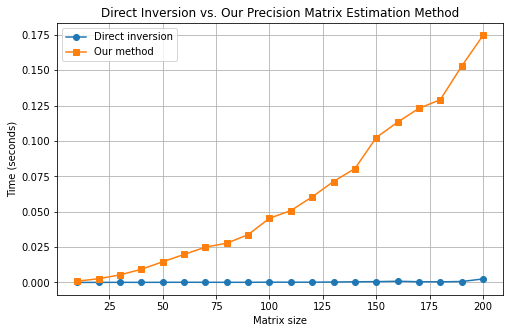

In [80]:
def kl_minimization_column(Theta_sk_sk):
    """
    Given the submatrix Theta_sk_sk corresponding to an index set sk,
    compute the vector L_sk solving a closed-form minimization problem.
    A regularization term is added for numerical stability.
    """
    reg = 1e-3 * np.eye(len(Theta_sk_sk))
    inv = np.linalg.inv(Theta_sk_sk + reg)
    e1 = np.zeros(len(inv))
    e1[0] = 1
    L_sk = inv @ e1
    L_sk /= np.sqrt(e1 @ inv @ e1)
    return L_sk

# -------------------------------------------------
# Data Generation
# -------------------------------------------------

np.random.seed(0)
n = 500      # Total number of points; we will use subsets of these.
d = 1
points = np.random.randn(n, d)

def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y)**2 / (2 * sigma**2))

# Precompute the full covariance matrix using the Gaussian kernel.
# (We will extract submatrices of various sizes from this.)
Theta_true = np.array([[gaussian_kernel(points[i], points[j])
                        for j in range(n)] for i in range(n)])

# -------------------------------------------------
# Timing Comparison over Varying Matrix Sizes
# -------------------------------------------------

# Parameters for timing
num_trials = 10       # average time over these many trials
sizes = list(range(10, 201, 10))   # Vary submatrix size from 10 up to 200
rho = 2               # Parameter for computing the sparsity pattern

direct_times = []
method_times = []

for matsize in sizes:
    direct_time_total = 0.0
    method_time_total = 0.0
    
    for trial in range(num_trials):
        # Select a subset of the points and corresponding covariance matrix.
        subset = np.arange(matsize)
        Theta_sub = Theta_true[np.ix_(subset, subset)] + 1e-3 * np.eye(matsize)
        
        # -------- Direct Inversion Timing --------
        start = time.perf_counter()
        Theta_inv_direct = np.linalg.inv(Theta_sub)
        direct_time_total += time.perf_counter() - start
        
        # -------- Our Sparse Method Timing --------
        start = time.perf_counter()
        
        # 1. Reorder points according to reverse maximin ordering.
        ordering = reverse_maximin_ordering(points[subset])
        points_perm = points[subset][ordering]
        Theta_sub_perm = Theta_sub[np.ix_(ordering, ordering)]
        
        # 2. Compute sparsity pattern in the permuted ordering.
        sparsity_perm = compute_sparsity_pattern_perm(points_perm, rho, max_neighbors)
        
        # 3. Compute the approximate factor L in the permuted ordering.
        L_perm = np.zeros((matsize, matsize))
        for i in range(matsize):
            # Use the sparsity pattern for the i-th column.
            sk = sparsity_perm[i]
            # Ensure that the diagonal (i) is included and appears first.
            if i not in sk:
                sk = [i]
            else:
                sk = [i] + [j for j in sk if j != i]
            Theta_sk_sk = Theta_sub_perm[np.ix_(sk, sk)]
            L_sk = kl_minimization_column(Theta_sk_sk)
            L_perm[sk, i] = L_sk
        
#         # 4. Reconstruct the approximate covariance and then compute its pseudo-inverse.
#         Theta_est_perm = np.linalg.pinv(L_perm @ L_perm.T)
        
#         # 5. Undo the permutation to return to the original ordering.
#         ip = np.argsort(ordering)
#         Theta_est = Theta_est_perm[np.ix_(ip, ip)]
        
        method_time_total += time.perf_counter() - start

    direct_times.append(direct_time_total / num_trials)
    method_times.append(method_time_total / num_trials)

# -------------------------------------------------
# Plot the Results
# -------------------------------------------------

plt.figure(figsize=(8, 5))
plt.plot(sizes, direct_times, 'o-', label="Direct inversion")
plt.plot(sizes, method_times, 's-', label="Our method")
plt.xlabel("Matrix size")
plt.ylabel("Time (seconds)")
plt.title("Direct Inversion vs. Our Precision Matrix Estimation Method")
plt.legend()
plt.grid(True)
plt.show()


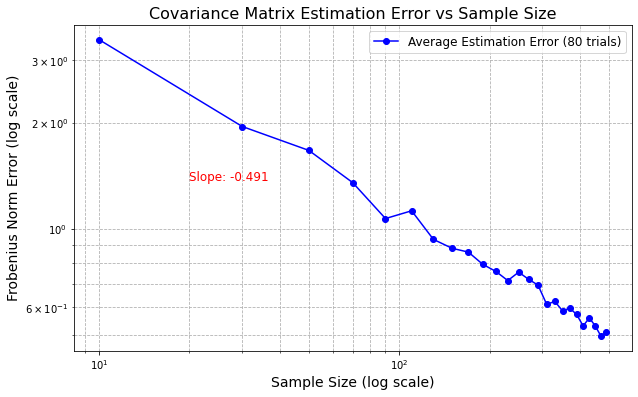

In [81]:
# ------------------------------
# Data Generation
# ------------------------------
np.random.seed(0)
n = 500  # total number of points for the full covariance
d = 1
points = np.random.randn(n, d)

def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y)**2 / (2 * sigma**2))

# Create the full 500×500 covariance matrix using the Gaussian kernel.
Theta_true = np.array([[gaussian_kernel(points[i], points[j]) 
                        for j in range(n)] for i in range(n)])

# ------------------------------
# Test Submatrix Setup (matsize = 10)
# ------------------------------
matsize = 10
subset = np.array(list(range(matsize)))
# Define the "true" 10x10 covariance for our test (with a little regularization).
Theta_sub_true = Theta_true[np.ix_(subset, subset)] + 1e-3 * np.eye(matsize)

# ------------------------------
# Experiment: Vary the Number of Samples
# ------------------------------
sample_sizes = np.arange(10, 501, 20)  # sample sizes from 10 to 500
num_trials = 80                       # average over 80 trials for each sample size
errors_avg = []                       # will store average error for each sample size
rho = 2                               # parameter for the sparsity pattern
max_neighbors = 100                  # Limit the number of neighbors per column.

for N in sample_sizes:
    trial_errors = []
    for trial in range(num_trials):
        # Generate N samples from N(0, Theta_sub_true)
        samples = np.random.multivariate_normal(mean=np.zeros(matsize), 
                                                cov=Theta_sub_true, 
                                                size=N)
        # Compute the sample covariance (biased estimator with 1/N normalization)
        Theta_sample = np.cov(samples, rowvar=False, bias=True)   #Each row is an independet observation
        
        # --- Apply your method to estimate the covariance ---
        # 1. Compute reverse maximin ordering (using the fixed subset points).
        ordering = reverse_maximin_ordering(points[subset])
        # 2. Permute the points and sample covariance into elimination order.
        points_perm = points[subset][ordering]
        Theta_sample_perm = Theta_sample[np.ix_(ordering, ordering)]
        # 3. Compute the sparsity pattern in the permuted ordering.
        sparsity_perm = compute_sparsity_pattern_perm(points_perm, rho, max_neighbors)
        # 4. Compute the approximate factor L (column-by-column).
        L_perm = np.zeros((matsize, matsize))      
        for i in range(matsize):
            sk = sparsity_perm[i]
            # Ensure the diagonal element is included and placed first.
            if i not in sk:
                sk = [i]
            else:
                sk = [i] + [j for j in sk if j != i]
            Theta_sk_sk = Theta_sample_perm[np.ix_(sk, sk)]
            L_sk = kl_minimization_column(Theta_sk_sk)
            L_perm[sk, i] = L_sk
        # 5. Reconstruct the estimated covariance from the factor L.
        Theta_est_perm = np.linalg.pinv(L_perm @ L_perm.T)
        # 6. Undo the permutation to return to the original ordering.
        ip = np.argsort(ordering)
        Theta_est = Theta_est_perm[np.ix_(ip, ip)]
        
        # Compute the Frobenius norm error between estimated and true covariance.
        error = np.linalg.norm(Theta_est - Theta_sub_true, 'fro')
        
#         error = np.linalg.norm(Theta_sample - Theta_sub_true, 'fro') #Test without Cholesky
        
        trial_errors.append(error)
    errors_avg.append(np.mean(trial_errors))

# ------------------------------
# Log-Log Analysis and Plotting
# ------------------------------
# Convert to log–log scale.
log_sample_sizes = np.log(sample_sizes)
log_errors_avg = np.log(errors_avg)

# Compute the slope via linear regression in log–log space.
slope, intercept = np.polyfit(log_sample_sizes, log_errors_avg, 1)

# Plot the results on logarithmic scales.
plt.figure(figsize=(10, 6))
plt.loglog(sample_sizes, errors_avg, 'bo-', label='Average Estimation Error (80 trials)')
plt.xlabel('Sample Size (log scale)', fontsize=14)
plt.ylabel('Frobenius Norm Error (log scale)', fontsize=14)
plt.title('Covariance Matrix Estimation Error vs Sample Size', fontsize=16)
plt.grid(True, which='both', linestyle='--')
plt.legend(fontsize=12)

# Display the slope on the plot.
plt.text(20, max(errors_avg) * 0.4, f'Slope: {slope:.3f}', fontsize=12, color='red')
plt.show()


## - Plot shows Monte Carlo sqrt(n) rate

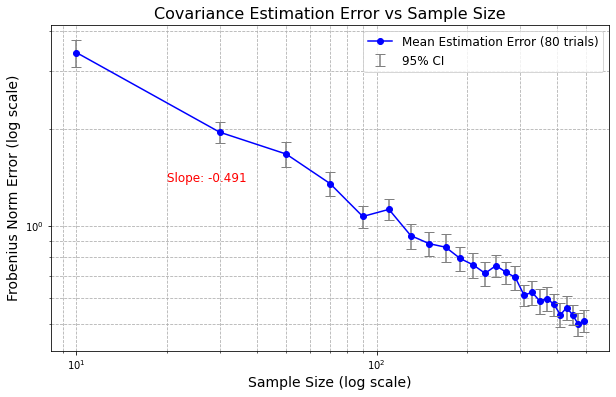

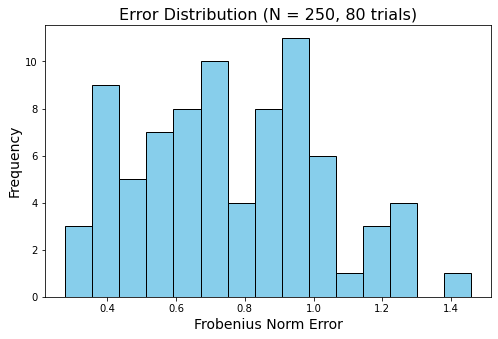

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

# ------------------------------
# Helper Functions
# ------------------------------
def boundary_dist_func(point):
    return np.linalg.norm(point)

def reverse_maximin_ordering(points):  
    """
    Order points from furthest to closest from the origin.
    Returns a permutation (list of indices).
    """
    n = points.shape[0]
    ordering = []
    remaining = set(range(n))
    while remaining:
        max_dist = -1
        next_point = -1
        for i in remaining:
            dist = boundary_dist_func(points[i])
            if dist > max_dist:
                max_dist = dist
                next_point = i
        ordering.append(next_point)
        remaining.remove(next_point)
    return ordering

def compute_sparsity_pattern_perm(points, rho, max_neighbors):
    """
    For points in the permuted (elimination) order, compute a sparsity pattern.
    For each point i, we find all indices j (with j >= i) that satisfy:
         distance(points[i], points[j]) <= rho * boundary_dist(points[i]),
    then we sort them by distance and keep at most max_neighbors entries.
    We ensure that the diagonal index (i) is included and placed first.
    """
    n = points.shape[0]
    tree = KDTree(points)
    sparsity = [[] for _ in range(n)]
    for i in range(n):
        radius = rho * boundary_dist_func(points[i])
        # Find all indices within the given radius.
        neighbors = tree.query_ball_point(points[i], radius)
        # Only keep indices that are >= i.
        neighbors = [j for j in neighbors if j >= i]
        # Sort neighbors by distance from points[i]
        neighbors = sorted(neighbors, key=lambda j: np.linalg.norm(points[j]-points[i]))
        # Ensure that i appears first.
        if i not in neighbors:
            neighbors = [i] + neighbors
        else:
            neighbors.remove(i)
            neighbors = [i] + neighbors
        # Restrict to at most max_neighbors.
        sparsity[i] = neighbors[:max_neighbors]
    return sparsity

def kl_minimization_column(Theta_sk_sk):
    """
    Given the submatrix Theta_sk_sk corresponding to an index set sk,
    compute the vector L_sk solving a closed-form minimization problem.
    A regularization term is added for numerical stability.
    """
    reg = 1e-3 * np.eye(len(Theta_sk_sk))
    # Uncomment the next line to see the size of the submatrix
    # print('Shape of sub_matrix used for inversion:', np.shape(Theta_sk_sk))
    inv = np.linalg.inv(Theta_sk_sk + reg)
    e1 = np.zeros(len(inv))
    e1[0] = 1
    L_sk = inv @ e1
    L_sk /= np.sqrt(e1 @ inv @ e1)
    return L_sk

# ------------------------------
# Data Generation
# ------------------------------
np.random.seed(0)
n = 500  # total number of points for the full covariance
d = 1
points = np.random.randn(n, d)

def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y)**2 / (2 * sigma**2))

# Create the full 500×500 covariance matrix using the Gaussian kernel.
Theta_true = np.array([[gaussian_kernel(points[i], points[j]) 
                        for j in range(n)] for i in range(n)])

# ------------------------------
# Test Submatrix Setup (matsize = 10)
# ------------------------------
matsize = 10
subset = np.array(list(range(matsize)))
# Define the "true" 10x10 covariance for our test (with a little regularization).
Theta_sub_true = Theta_true[np.ix_(subset, subset)] + 1e-3 * np.eye(matsize)

# ------------------------------
# Experiment: Vary the Number of Samples
# ------------------------------
sample_sizes = np.arange(10, 501, 20)  # sample sizes from 10 to 500
num_trials = 80                       # number of trials per sample size
errors_by_sample = {}                 # to store trial errors for each sample size

rho = 2                               # parameter for the sparsity pattern
max_neighbors = 100                   # limit on neighbors (here, in a 10x10 submatrix, it might be all)

for N in sample_sizes:
    trial_errors = []
    for trial in range(num_trials):
        # Generate N samples from N(0, Theta_sub_true)
        samples = np.random.multivariate_normal(mean=np.zeros(matsize), 
                                                cov=Theta_sub_true, 
                                                size=N)
        # Compute the sample covariance (biased estimator with 1/N normalization)
        Theta_sample = np.cov(samples, rowvar=False, bias=True)
        
        # --- Apply the method to estimate the covariance ---
        # 1. Compute reverse maximin ordering (using the fixed subset points).
        ordering = reverse_maximin_ordering(points[subset])
        # 2. Permute the points and sample covariance into elimination order.
        points_perm = points[subset][ordering]
        Theta_sample_perm = Theta_sample[np.ix_(ordering, ordering)]
        # 3. Compute the sparsity pattern in the permuted ordering.
        sparsity_perm = compute_sparsity_pattern_perm(points_perm, rho, max_neighbors)
        # 4. Compute the approximate factor L (column-by-column).
        L_perm = np.zeros((matsize, matsize))
        for i in range(matsize):
            sk = sparsity_perm[i]
            # Ensure the diagonal element is included and placed first.
            if i not in sk:
                sk = [i]
            else:
                sk = [i] + [j for j in sk if j != i]
            Theta_sk_sk = Theta_sample_perm[np.ix_(sk, sk)]
            L_sk = kl_minimization_column(Theta_sk_sk)
            L_perm[sk, i] = L_sk
        # 5. Reconstruct the estimated covariance from the factor L.
        Theta_est_perm = np.linalg.pinv(L_perm @ L_perm.T)
        # 6. Undo the permutation to return to the original ordering.
        ip = np.argsort(ordering)
        Theta_est = Theta_est_perm[np.ix_(ip, ip)]
        
        # Compute the Frobenius norm error between estimated and true covariance.
        error = np.linalg.norm(Theta_est - Theta_sub_true, 'fro')
        trial_errors.append(error)
    errors_by_sample[N] = trial_errors

# Compute mean error and 95% confidence intervals for each sample size.
sample_means = []
lower_bounds = []
upper_bounds = []

for N in sample_sizes:
    errors = np.array(errors_by_sample[N])
    mean_err = np.mean(errors)
    std_err = np.std(errors, ddof=1) / np.sqrt(num_trials)
    # 95% CI using normal approximation (t-value ~1.96 for large num_trials)
    ci_half_width = 1.96 * std_err
    sample_means.append(mean_err)
    lower_bounds.append(mean_err - ci_half_width)
    upper_bounds.append(mean_err + ci_half_width)

# ------------------------------
# Log-Log Analysis and Plotting
# ------------------------------
log_sample_sizes = np.log(sample_sizes)
log_means = np.log(sample_means)
slope, intercept = np.polyfit(log_sample_sizes, log_means, 1)

plt.figure(figsize=(10, 6))
plt.loglog(sample_sizes, sample_means, 'bo-', label='Mean Estimation Error (80 trials)')
plt.errorbar(sample_sizes, sample_means, 
             yerr=[np.array(sample_means) - np.array(lower_bounds), 
                   np.array(upper_bounds) - np.array(sample_means)], 
             fmt='none', ecolor='gray', capsize=5, label='95% CI')
plt.xlabel('Sample Size (log scale)', fontsize=14)
plt.ylabel('Frobenius Norm Error (log scale)', fontsize=14)
plt.title('Covariance Estimation Error vs Sample Size', fontsize=16)
plt.grid(True, which='both', linestyle='--')
plt.legend(fontsize=12)
plt.text(20, max(sample_means) * 0.4, f'Slope: {slope:.3f}', fontsize=12, color='red')
plt.show()

# ------------------------------
# Plot the error distribution for one sample size
# ------------------------------
# For example, plot the histogram of errors for sample size = 250.
selected_N = 250
errors_selected = errors_by_sample[selected_N]

plt.figure(figsize=(8, 5))
plt.hist(errors_selected, bins=15, color='skyblue', edgecolor='black')
plt.xlabel('Frobenius Norm Error', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Error Distribution (N = {selected_N}, 80 trials)', fontsize=16)
plt.show()
